# Vehicle Detection and Tracking

The goals/steps of this notebook are to:
1. Search an image/video frame for detection,
2. Handle multiple detections and false positives, and,
3. Track the detection frame by frame

## 1. Setup

In [1]:
# Necessary imports

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import time
import glob

from scipy.ndimage.measurements import label

%matplotlib inline

C:\Users\Gatik\AppData\Local\Temp\ipykernel_12380\3846033503.py:11: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [2]:
from helper_functions import *

In [3]:
### Load pickled data

data = pickle.load(open('classifier_data.p', mode='rb'))
svc = data['clf']
scaler = data['scaler']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data['cell_per_block']
spatial_size = data['spatial_size']
hist_bins = data['hist_bins']
cspace = data['color_space']
data

{'clf': LinearSVC(),
 'scaler': StandardScaler(),
 'orient': 9,
 'pix_per_cell': 8,
 'cell_per_block': 2,
 'spatial_size': (16, 16),
 'hist_bins': 24,
 'color_space': 'YCrCb'}

## 2. Searching for detections; Handling multiple detections and false positives

In [4]:
def find_cars(img, ystart, ystop, scale, svc, scaler, orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins, cspace):
    '''
    HOG Sub-sampling window search
    
    This function builds upon on the Sliding Window approach but instead of computing the expensive
    HOG features for every multi-scale window, it extracts the HOG features just once and subsamples it
    to search for detections over all the different multi-scale windows within the search area.
    Each window is defined by a scaling factor where a scale of 1 would result in a window that's
    8x8 cells and each cell has 8x8 pixels. The overlap of each window is in terms of the cell distance.
    This means that a cells_per_step = 2 would result in a search window overlap of 75%.
    
    :param img(ndarray): Frame
    :param ystart(int): Search area low y-coordinate 
    :param ystop(int): Search area high y-coordinate 
    :param scale(float): Window scale
    :param svc(LinearSVC): Instance of the trained Linear SVC 
    :param scaler(StandardScaler): Instance of the Standard Scaler fitted over the training set
    :param orient(int): Number of orientation bins; param for extracting HOG features
    :param pix_per_cell(int): Number of pixels per cell; param for extracting HOG features
    :param cell_per_block(int): Number of cells per block; param for extracting HOG features
    :param spatial_size((int, int)): Spatial bin size; param for extracting raw color values
    :param hist_bins(int): Number histogram bins; param for extracting Histogram of color values
    :param cspace(string): Color space in which to extract the features
    :return : Tuple (List of bounding boxes of detections, Image with the detection bounding boxes drawn,
                        Image with all the search windows drawn)
    '''
    
    # Note: The number of features are maintained across the multi-scaled windows by:
    # 1. Making sure the window size = size of the image that we trained with i.e. 64x64
    # 2. By resizing the image to achieve the effect of larger/smaller window
    
    detections_img = np.copy(img)
    draw_wins_img = np.copy(img)
    bbox_list = []
    
    img = img.astype(np.float32)/255

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace=cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps. Note: cells > blocks > windows
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64 # 64 is the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            box_left = np.int(xleft*scale)
            box_top = np.int(ytop*scale)
            win = np.int(window*scale)
            bbox = ((box_left, box_top + ystart), (box_left + win, box_top + win + ystart))

            cv2.rectangle(draw_wins_img, bbox[0], bbox[1], (0,255,0), 6) 
            
            # TODO: Try the decision_function here...
            if test_prediction == 1:               
                bbox_list.append(bbox)
                cv2.rectangle(detections_img, bbox[0], bbox[1], (0,0,255), 6) 
                
    return bbox_list, detections_img, draw_wins_img

def add_heat(heatmap, bbox_list):
    '''
    Function to add heat to heatmap for a list of bounding boxes
    :param heatmap(ndarray): Heatmap, same size as that of an image/video frame
    :param bbox_list([((x1,y1), (x2,y2))]): List of bounding boxes
    :return (ndarray): Updated Heatmap
    '''
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    '''
    Function that zeros out all the pixels in a heatmap that are below a user defined threshold
    :param heatmap(ndarray): Heatmap
    :param threshold(int): Threshold
    :return (ndarray): Updated heatmap
    '''
    
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    '''
    Function that takes in the labelled detections in a heatmap and puts bounding
    boxes in the original image around the labelled regions.
    :param img(ndarray): Image
    :param labels(Tuple): Labelled detections in a heatmap obtained by using
                            'scipy.ndimage.measurements.label'
    :return: Image with the bounding boxes around the labelled detections,
                List of Bounding boxes of the detections
    '''
    
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
        bboxes.append(bbox)
        
    return img, bboxes

### 2.1 Demo

C:\Users\Gatik\AppData\Local\Temp\ipykernel_12380\2488507486.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  heat = np.zeros_like(img[:,:,0]).astype(np.float) # Create the heat map
C:\Users\Gatik\AppData\Local\Temp\ipykernel_12380\3108076852.py:90: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and 

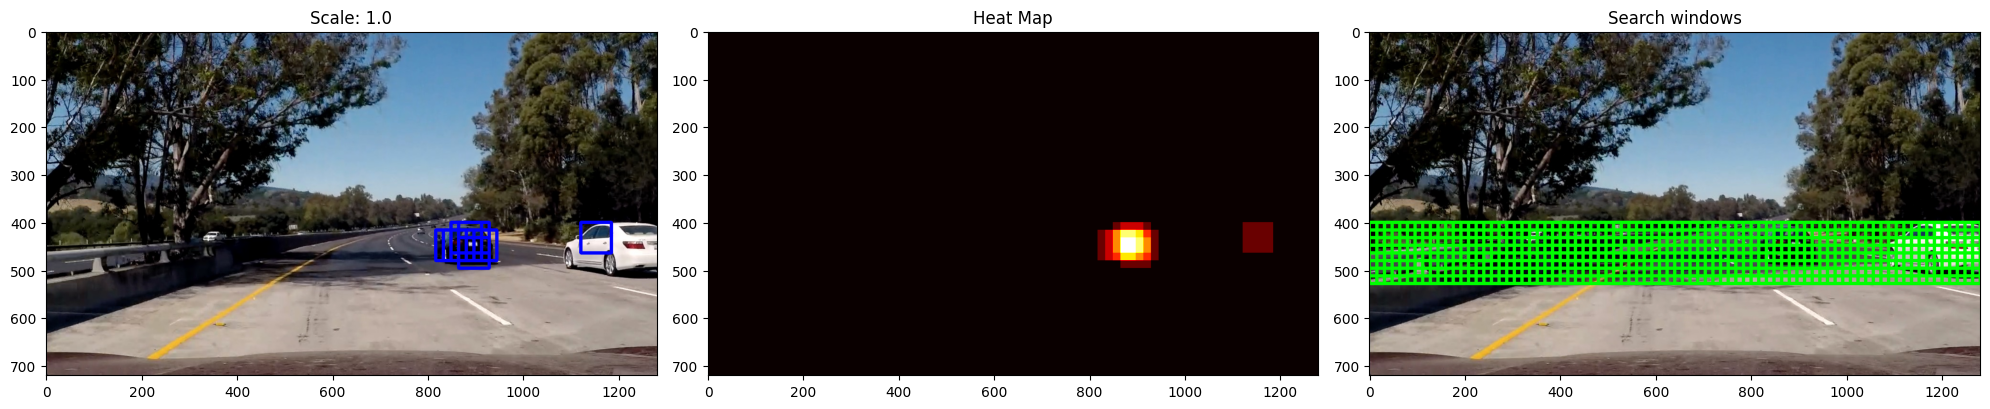

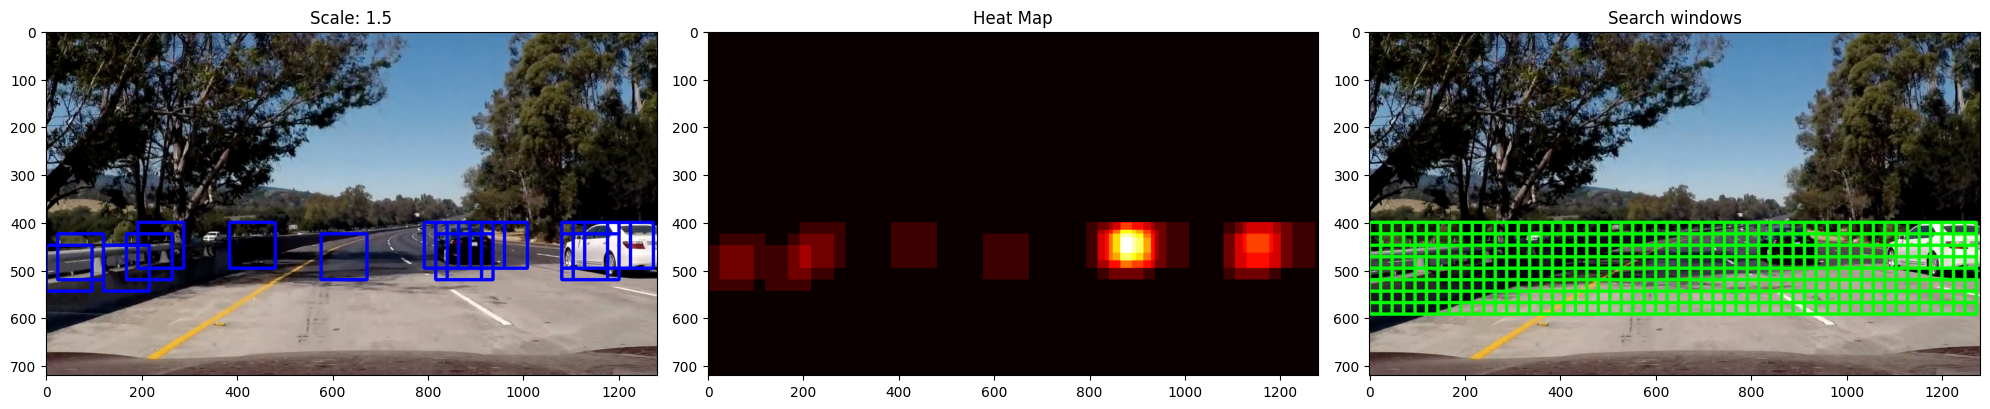

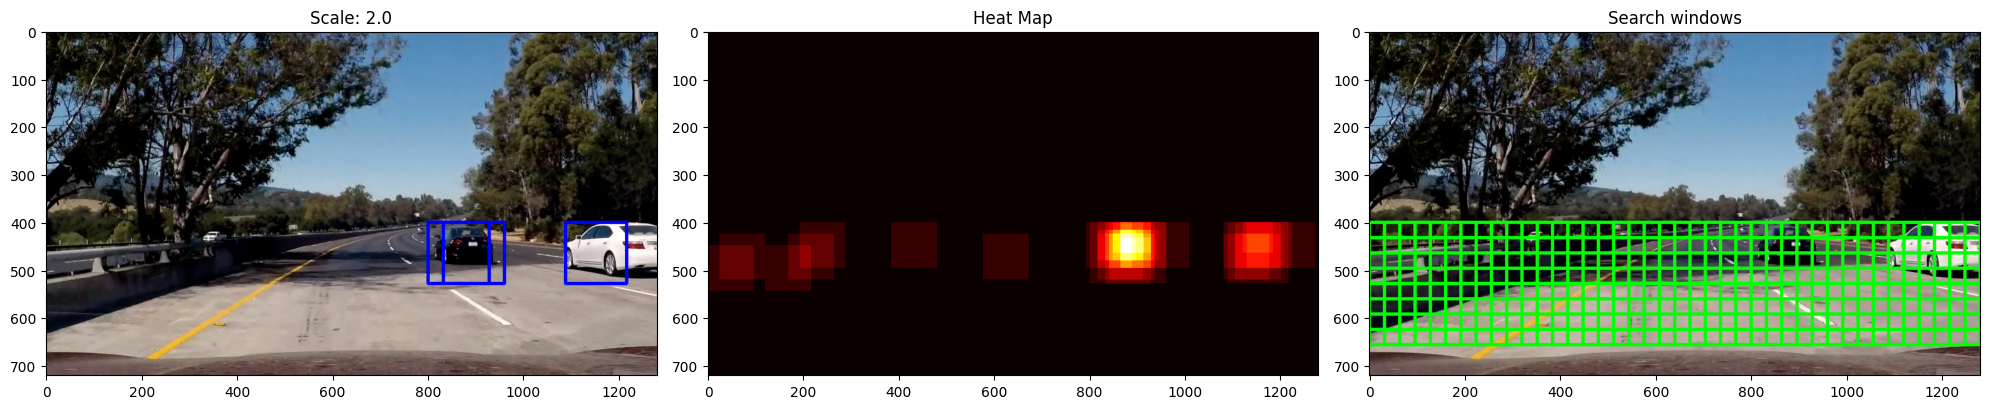

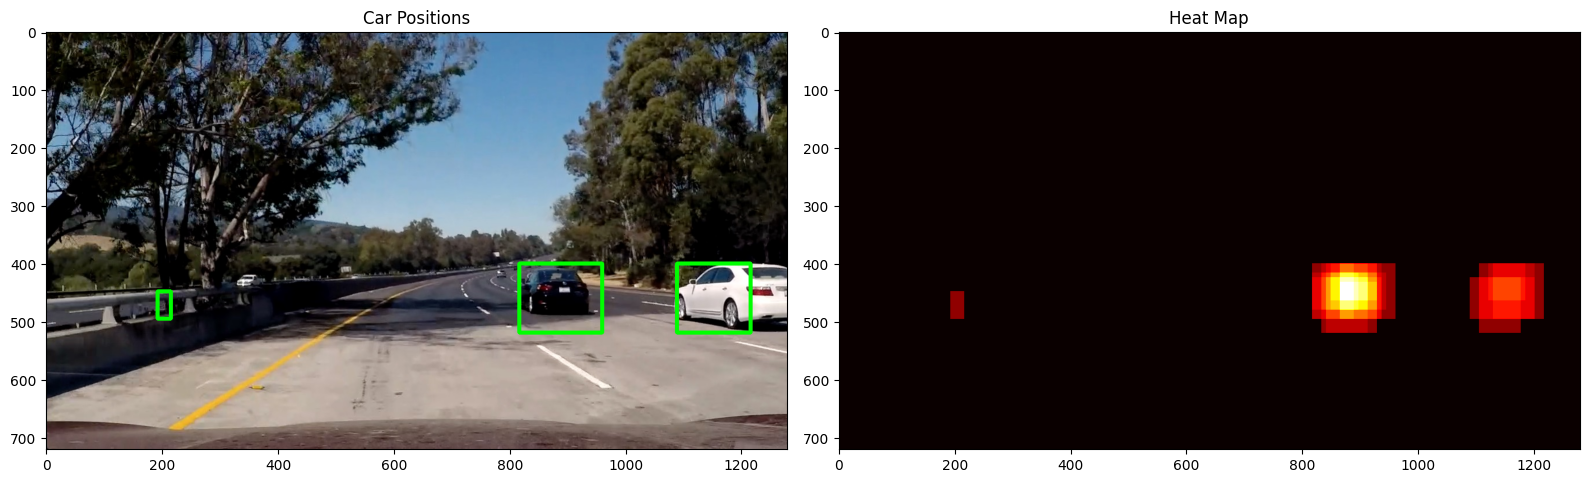

In [5]:
test_img_paths = glob.glob('test_images/*.jpg') 

for img_path in test_img_paths[-2:-1]:
    img = mpimg.imread(img_path)
    heat = np.zeros_like(img[:,:,0]).astype(np.float) # Create the heat map

    # Define multi-scale windows
    scales = [1.0, 1.5, 2.0]
    # Define section of the image where the search needs to be performed
    ystarts = [400, 400, 400]
    ystops = [528, 592, 656]
    
    for scale, ystart, ystop in zip(scales, ystarts, ystops):
        bbox_list, detections_img, wins_img  = find_cars(img, ystart, ystop, scale,
                                                        svc, scaler, orient, pix_per_cell,
                                                        cell_per_block, spatial_size, hist_bins, cspace)
        heat = add_heat(heat, bbox_list)

        fig = plt.figure(figsize = (20,16))
        plt.subplot(131)
        plt.imshow(detections_img)
        plt.title('Scale: ' +  str(scale))
        plt.subplot(132)
        plt.imshow(heat, cmap='hot')
        plt.title('Heat Map')
        plt.subplot(133)
        plt.title('Search windows')
        plt.imshow(wins_img)
        fig.tight_layout()

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img, bbx = draw_labeled_bboxes(np.copy(img), labels)
    
    fig = plt.figure(figsize = (16,16))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()

## 3. Pipeline

In [6]:
from collections import deque

def add_heat_and_threshold(img, bboxes):
    heatmap = np.zeros_like(img[:,:,0], dtype=np.float)
    heatmap = add_heat(heatmap, bboxes)
    heatmap = apply_threshold(heatmap, 2)
    heatmap = np.clip(heatmap, 0, 255)
    labels = label(heatmap)
    _, thresh_bboxes = draw_labeled_bboxes(np.copy(img), labels)
    return thresh_bboxes

class Tracker(object):
    def __init__(self):
        '''
        Wrapper class that processes each video frame by:
        1. Extracting features (Raw color values/ Histogram of color values/ HOG)
        2. Searching for detection
        3. Handling multiple detections and false positives
        4. Tracking the detections frame by frame and reducing the jitter in detections by looking
        the past history of detections.
        '''
        
        self.nb_frames = 0 # Number of processed frames
        self.cache = deque(maxlen=12) # Cache to store the detections over the past 12 frames, i.e. ~0.5secs
        self.new_ystop = 0 # New vertical stop limit for the search area
        self.curr_bboxes = [] # List of bounding boxes for the current detections
        
    def process_frame(self, img): 
        '''
        Function that:
        * Performs HOG Sub-sampling window search every 12 frames i.e. ~ 0.5 secs, and a,
        * Reduced window search every 6 frames which only scans the region of interest
          at where vehicle were previously detected.
          
        :param img(ndarray): Frame
        :return (ndarray): Processed frame with the higlighted detections
        '''
        
        heatmap = np.zeros_like(img[:,:,0], dtype=np.float)
        
        # Define section of the image where the search needs to be performed
        ystarts = [400, 400, 400, 400]
        ystops = [496, 528, 592, 656]
        # Define multi-scale windows for searching vehicles
        scales = [1., 1.25, 1.5, 1.75]
        
        bboxes_list = []
        if self.nb_frames % 12 == 0:
            for scale, ystart, ystop in zip(scales, ystarts, ystops):
                bboxes, detections_img, wins_img = find_cars(img, ystart, ystop, scale,
                                                        svc, scaler, orient, pix_per_cell,
                                                        cell_per_block, spatial_size, hist_bins, cspace)
                bboxes_list.extend(bboxes)

            thres_bboxes = add_heat_and_threshold(img, bboxes_list)
            out = self.draw_detections(img, thres_bboxes)
        
        elif (self.nb_frames % 6 == 0) and (self.new_ystop > 0):
            ystops = [self.new_ystop if y > self.new_ystop else y for y in ystops]
            for scale, ystart, ystop in zip(scales, ystarts, ystops):
                bboxes, detections_img, wins_img = find_cars(img, ystart, ystop, scale,
                                                        svc, scaler, orient, pix_per_cell,
                                                        cell_per_block, spatial_size, hist_bins, cspace)
                bboxes_list.extend(bboxes)

            thres_bboxes = add_heat_and_threshold(img, bboxes_list)
            out = self.draw_detections(img, thres_bboxes)
            
        else:
            out = draw_boxes(img, self.curr_bboxes)
        
        self.nb_frames += 1
        return out
    
    def draw_detections(self, img, thres_bboxes):
        '''
        Draws the bounding boxes for the detections and reduces the jitter
        by leveraging the history of detections over the past 12 frames
        :param (ndarray): Frame
        :param thresh_boxes(List of Tuples): List of bounding boxes for the detections
                                            in the current frame
        :return (ndarray): Frame with the detections higlighted
        '''
        self.cache.append(thres_bboxes)
        heatmap = np.zeros_like(img[:,:,0], dtype=np.float)
        
        for bboxes in self.cache:
            heatmap = add_heat(heatmap, bboxes)
            
        heatmap = apply_threshold(heatmap, len(self.cache) // 3)
        heatmap = np.clip(heatmap, 0, 255)
        labels = label(heatmap)
        draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
        
        if np.array(bboxes).any():
            self.curr_bboxes = bboxes
            self.new_ystop = np.amax(np.array(bboxes), axis=0)[1,1] + 64
        else:
            self.new_ystop = 0

        return draw_img

## 4. Process the video

In [7]:
from moviepy.editor import VideoFileClip

tracker = Tracker()

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
video_clip = video_input.fl_image(tracker.process_frame)
%time video_clip.write_videofile(video_output, audio=False)

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
CPU times: total: 11min 31s
Wall time: 11min 59s


In [ ]:
# print(np.array(bbx))
# np.amax(np.array(bbx), axis=0)